In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.utils import resample, shuffle
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Load data
df = pd.read_csv("Attrition_dataset.csv")

# Drop unwanted columns
df = df.drop(columns=['Date_of_termination', 'Unnamed: 32', 'Date_of_Hire'], errors='ignore')

# Resampling to balance the dataset
Attrition_no = df[df.Attrition == 'No']
Attrition_yes = df[df.Attrition == 'Yes']
df_minority = resample(Attrition_yes, replace=True, n_samples=len(Attrition_no), random_state=123)
df = pd.concat([Attrition_no, df_minority])
df = shuffle(df, random_state=42)

# Label encoding
label_enc = LabelEncoder()
df['Attrition'] = label_enc.fit_transform(df['Attrition'])  # Yes=1, No=0
df['Higher_Education'] = label_enc.fit_transform(df['Higher_Education'])

# Binary label encoding
binary_cols = ['Gender', 'OverTime', 'Work_accident']
for col in binary_cols:
    df[col] = label_enc.fit_transform(df[col])

# One-hot encode remaining categoricals
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Drop unwanted columns
df = df.drop(columns=['MonthlyIncome', 'Department_Sales'], errors='ignore')

# Outlier handling
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Attrition')

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    col_mean = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)][col].mean()
    if pd.api.types.is_integer_dtype(df[col]):
        col_mean = int(round(col_mean))
    df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = col_mean

# Separate features and target
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Feature selection using Chi2 and ANOVA
chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(X, y)
chi2_scores = pd.Series(chi2_selector.scores_, index=X.columns).sort_values(ascending=False)

anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(X, y)
anova_scores = pd.Series(anova_selector.scores_, index=X.columns).sort_values(ascending=False)

# Combine top features
top_n = 25
top_chi2_features = set(chi2_scores.head(top_n).index)
top_anova_features = set(anova_scores.head(top_n).index)
common_features = list(top_chi2_features.intersection(top_anova_features))
X_selected = X[common_features]

selector = VarianceThreshold(threshold=0.0)
X_selected = selector.fit_transform(X)


if np.any(np.isnan(X_selected)) or np.any(np.isinf(X_selected)):
    X_selected = np.nan_to_num(X_selected, nan=np.nanmean(X_selected, axis=0))

# Feature Scaling
scaler = MinMaxScaler()
X_selected_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y, test_size=0.3, stratify=y, random_state=42)

# GridSearchCV for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
# print("Best Parameters:", grid_search.best_params_)

# Evaluation
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output results
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("F1 Score:", f1)
# print("Confusion Matrix:\n", conf_matrix)



C:\Users\padia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\padia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Fitting 5 folds for each of 24 candidates, totalling 120 fits



Classification Report:
               precision    recall  f1-score   support

 No Attrition       0.98      0.96      0.97       370
Yes Attrition       0.96      0.98      0.97       370

     accuracy                           0.97       740
    macro avg       0.97      0.97      0.97       740
 weighted avg       0.97      0.97      0.97       740



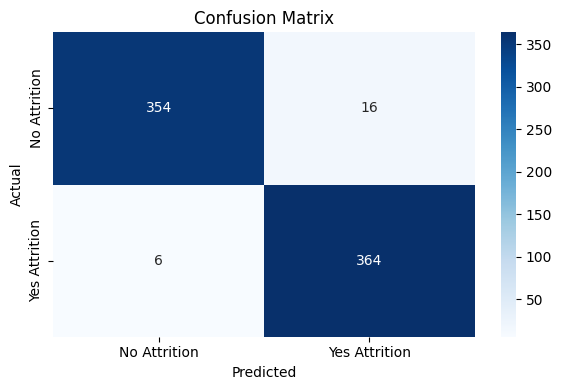

In [7]:
from sklearn.metrics import classification_report

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Attrition", "Yes Attrition"]))

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Attrition", "Yes Attrition"],
            yticklabels=["No Attrition", "Yes Attrition"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
